iteration 1
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 102, constraints m = 166
          nnz(P) + nnz(A) = 456
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.4670e+01   5.09e-02   4.80e+00   1.00e-01   2.81e-04s
  25  -1.6158e+01   5.20e-04   1.11e-04   1.00e-01   5.33e-04s

status:               solved
num

C:\Users\lydia\Desktop\resources\2021 sem1\mpc code\linearised_mpc_new.py:258: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan((centerpoints[1, i+1]-centerpoints[1,i])/(centerpoints[0,i+1]-centerpoints[0,i]))


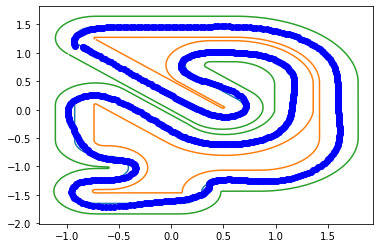

In [1]:
import osqp
import quadprog
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import sparse
import scipy as sp
#import interpolate as ip
import socket, time
from scipy.linalg import block_diag
from scipy.linalg import block_diag
from linearised_mpc_new import LTVMPC
from linearised_mpc_new import unicycleODE
from scipy.integrate import solve_ivp
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import sparse


track_ref = scipy.io.loadmat('track.mat')
track2 = np.array(track_ref['track'])

##### loading trajectory
track1=track2[0,0]
track_inner = track1[0]
track_outer = track1[1]
track_center = track1[2]
xPath = track_center[0]
yPath = track_center[1]
xCenter =track_center[0]
yCenter = track_center[1]
xInner = track_inner[0]
yInner = track_inner[1]
xOuter = track_outer[0]
yOuter = track_outer[1]
centerPoints = np.vstack([xCenter, yCenter])
innerPoints = np.vstack([xInner, yInner])
outerPoints = np.vstack([xOuter, yOuter])
innerPoints = np.vstack([xInner, yInner])

xRef = xPath
yRef = yPath
thetaRef = np.zeros((xPath.shape[0]))
vRef = np.zeros((xPath.shape[0]))
xiRef = np.vstack([xPath, yPath, thetaRef, vRef])

xTrackMin = np.min([xInner, xOuter])
xTrackMax = np.max([xInner, xOuter])
yTrackMin = np.min([xInner, xOuter])
yTrackMax = np.max([xInner, xOuter])

# define constraints here
constr={}
constr['thetaMax']=math.inf
constr['thetaMin']=-math.inf
constr['vmax']=2
constr['vmin']=0
constr['amax'] = 1
constr['amin'] = -1
constr['omegamax'] = 5
constr['omegamin'] = -5

n_upper = 16
M = 1
T = 0.05
tspan = np.array([0,0])


startTime = 0
endTime = T*(xRef.shape[0]-1)
times = np.arange(startTime, endTime, T)


nState = 4
nInput = 2
nPosition = 2
nEta = nState-nPosition


vInitial = 0
omegaInitial = 0
aInitial = 0
thetaInitial = np.arctan((yRef[1] - yRef[0])/(xRef[1] - xRef[0]))
# xi = np.vstack([xRef[0],yRef[0],thetaInitial,vInitial])
# u = np.vstack([omegaInitial, aInitial])
xi = np.array([[xRef[0]], [yRef[0]], [thetaInitial], [vInitial]],dtype=float).reshape(4,1)
u = np.array([omegaInitial, aInitial],dtype=float).reshape(2,1)
xipred = np.zeros((xi.shape[0], n_upper+1))
upred = np.matlib.repmat(u, 1, n_upper+1)

q = 20*np.diag(np.array([1,1,0,0]))
r = 5*np.diag(np.array([1,1]))
# q=20*sparse.diags([1,1,0,0])
# r=5*sparse.diags([1,1])

uhis = np.zeros((2,1))
# xihis = np.array([])
xihis = xi
epssim = np.array([])
tspan = np.array([0,0])
x = np.array([])
y = np.array([])
xiRef = np.hstack([xiRef, xiRef[:,0:n_upper]])

centerpoints = np.hstack([centerPoints,centerPoints[:,0:n_upper]])


plt.plot(xCenter, yCenter)
plt.plot(xInner, yInner)
plt.plot(xOuter,yOuter)

for k in range(1,times.shape[0]+1): #times.shape[0]+1):
    print('iteration',k)
    [upred,xipred,epscurr] = LTVMPC(q,r,n_upper,M,T,xiRef[:,k-1:k+n_upper],centerpoints[:,k-1:k+n_upper],xi,\
                                    upred[:,0:n_upper+1],constr)
    # print('upred=',upred)
    # print('xipred=',xipred)

    tspan = np.array([tspan[1],tspan[1]+T])
    # print('xi', xi[0:nState,0])
    # print('upred',upred[0:nInput,1])
    # print('tspan',tspan)
    sol = solve_ivp(unicycleODE, tspan, xi[0:nState,0],method='RK45', args=(upred[0,1],upred[1,1]),
                dense_output=True)
    # results = scipy.integrate.RK45(fun=unicycleODE(0, xi[0:nState,0],upred[0:nInput,1]), t0=tspan[0], y0=xinit.reshape(4,),t_bound=tspan[1])
    print('results',sol.y)
    xi = sol.y[0:4,np.shape(sol.y)[1]-1].reshape(4,1)
    xihis = np.hstack([xihis, xi])
    #print('xihist=',xihis)
    x = np.append(x,sol.y[0,np.shape(sol.y)[1]-1])
    y = np.append(y,sol.y[1,np.shape(sol.y)[1]-1])
    uhis = np.hstack([uhis, upred[0:2,1].reshape(2,1)])
    epssim = np.hstack([epssim,epscurr])
    #print('size=',xihis.shape)
    plt.plot(sol.y[0,np.shape(sol.y)[1]-1],sol.y[1,np.shape(sol.y)[1]-1],'bo')
    # print(upred[:,1:n_upper+1],upred[:,n_upper])
    upred = np.hstack([upred[:,1:n_upper+1], upred[:,n_upper].reshape(2,1)])
